In [1]:
!pip install pandas pyarrow matplotlib seaborn numpy python-dateutil tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 119.7 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [seaborn]m1/2 [seaborn]


In [23]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

# --- Paths (ปรับตามโปรเจ็กต์ได้) ---
RAW_DIR     = Path("/teamspace/studios/this_studio/data/dengue/raw")
INTERIM_DIR = Path("/teamspace/studios/this_studio/data/dengue/interim")
REPORT_DIR  = Path("/teamspace/studios/this_studio/data/dengue/reports")

INTERIM_DIR.mkdir(parents=True, exist_ok=True)
REPORT_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", 200)


In [24]:
# --- ชื่อคอลัมน์มาตรฐาน ---
CANONICAL = {
    "discode":"discode",
    "sex":"sex","Sex":"sex",
    "agey":"agey","agem":"agem","aged":"aged",
    "nation":"nation",
    "occupat":"occupation","occupation":"occupation",
    "addercode":"addercode",
    "metropol":"metropol",
    "treatmentloc":"treatmentloc",
    "patienttype":"patienttype",
    "results":"results",
    "treatmentloccod":"treatmentloccod",
    "datesick":"datesick",
    "datedefine":"datedefine",
    "datefound":"datefound",
    "datedeath":"datedeath",
    "germ":"germ",
    "complications":"complications",
    "district":"district",
    "province":"province",
}

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    new = {}
    for c in df.columns:
        s = str(c).strip()
        if s in CANONICAL:
            new[c] = CANONICAL[s]
        else:
            low = s.lower()
            new[c] = CANONICAL.get(low, low)
    return df.rename(columns=new)

# --- แปลงวันที่ให้ robust: รองรับ 00/00/0000, 0000-00-00, 00-00-0000 ---
BAD_DATE_PAT = re.compile(r"^(?:0{2}[/\-]0{2}[/\-]0{4}|0{4}[-/]0{2}[-/]0{2})$")

DATE_FORMATS = ["%m/%d/%Y","%d/%m/%Y","%Y-%m-%d","%d-%m-%Y","%m-%d-%Y"]

def parse_date_series(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    s = s.mask(s.eq("") | s.eq("NaN") | s.map(lambda x: bool(BAD_DATE_PAT.match(x))))
    out = pd.to_datetime(s, errors="coerce")
    if out.isna().mean() > 0.5:
        out2 = None
        for fmt in DATE_FORMATS:
            tr = pd.to_datetime(s, errors="coerce", format=fmt)
            out2 = tr if out2 is None else out2.fillna(tr)
        out = out.fillna(out2)
    return out

def clean_thai_cat(x: pd.Series) -> pd.Series:
    y = x.astype(str).str.strip()
    y = y.str.replace(r"\s+", " ", regex=True)
    y = y.str.replace("อบต.", "อบต", regex=False)
    y = y.str.replace("ไม่ทราบอาชีพ", "ไม่ทราบ", regex=False)
    return y.replace({"nan": np.nan, "": np.nan})

def normalize_sex(s: pd.Series) -> pd.Series:
    t = s.astype(str).str.strip()
    t = t.replace({"1":"ชาย","2":"หญิง"})
    return t.replace({"nan": np.nan, "": np.nan})

def age_to_years(df: pd.DataFrame) -> pd.Series:
    for c in ["agey","agem","aged"]:
        if c not in df: df[c] = 0
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)
    return df["agey"] + df["agem"]/12.0 + df["aged"]/365.0


In [25]:
def load_clean_one(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, dtype=str, encoding="utf-8")
    df = normalize_columns(df)

    # เติมคอลัมน์ที่ขาดให้ครบ schema
    for c in ["sex","agey","agem","aged","nation","occupation","addercode","metropol",
              "treatmentloc","patienttype","results","treatmentloccod",
              "datesick","datedefine","datefound","datedeath",
              "germ","complications","district","province"]:
        if c not in df: df[c] = np.nan

    # clean
    for c in ["nation","occupation","addercode","metropol","treatmentloc",
              "patienttype","results","district","province"]:
        df[c] = clean_thai_cat(df[c])
    df["sex"] = normalize_sex(df["sex"])

    # วันที่
    for c in ["datesick","datedefine","datefound","datedeath"]:
        df[c] = parse_date_series(df[c])

    # อายุทศนิยม
    df["age_years"] = age_to_years(df)

    # คีย์ข้อความ (ไว้ใช้ EDA/โมเดล) + year hint
    df["district_id_txt"] = df["district"].fillna("").str.strip() + "|" + df["province"].fillna("").str.strip()
    m = re.search(r"(25\d{2}|20\d{2})", path.name)
    df["source_year_hint"] = m.group(1) if m else np.nan

    # ทำ addercode ให้เป็นตัวเลขล้วน
    df["addercode"] = df["addercode"].str.replace(r"\D+", "", regex=True)

    return df

files = sorted(RAW_DIR.glob("Dengue_odpc4_*.csv"))
assert files, f"No input files found in {RAW_DIR}"
dfs = [load_clean_one(p) for p in files]
raw_all = pd.concat(dfs, ignore_index=True)

print("Rows:", len(raw_all))
display(raw_all.head())


Rows: 19350


,discode,sex,agey,agem,aged,nation,occupation,addercode,metropol,treatmentloc,patienttype,results,treatmentloccod,datesick,datedefine,datefound,datedeath,germ,complications,district,province,age_years,district_id_txt,source_year_hint
0,66,หญิง,17,5,19,ไทย,ไม่ทราบ,26020302,อบต,ร.พ.ชุมชน,ผู้ป่วยนอก,ยังรักษาอยู่,26020300,2018-01-01,2018-01-01,2018-01-01,NaT,NaN,NaN,ปากพลี,นครนายก,17.468721,ปากพลี|นครนายก,2561
1,66,หญิง,25,0,0,ไทย,รับจ้าง-กรรมกร,26040104,อบต,ร.พ.ชุมชน,ผู้ป่วยใน,หาย,26041000,2018-01-01,2018-01-01,2018-01-01,NaT,9,0,องครักษ์,นครนายก,25.000000,องครักษ์|นครนายก,2561
2,66,ชาย,23,0,0,ไทย,รับจ้าง-กรรมกร,26040104,อบต,ร.พ.ชุมชน,ผู้ป่วยใน,หาย,26041000,2018-01-01,2018-01-01,2018-01-01,NaT,9,0,องครักษ์,นครนายก,23.000000,องครักษ์|นครนายก,2561
3,66,ชาย,19,1,19,ไทย,ไม่ทราบ,26020302,อบต,ร.พ.ชุมชน,ผู้ป่วยนอก,ยังรักษาอยู่,26020300,2018-01-01,2018-01-01,2018-01-01,NaT,NaN,NaN,ปากพลี,นครนายก,19.135388,ปากพลี|นครนายก,2561
4,66,ชาย,42,7,29,ไทย,รับจ้าง-กรรมกร,26020704,อบต,ร.พ.ชุมชน,ผู้ป่วยนอก,หาย,26020300,2018-01-01,2018-01-01,2018-01-01,NaT,NaN,NaN,ปากพลี,นครนายก,42.662785,ปากพลี|นครนายก,2561


In [26]:
tmp = raw_all.copy()
tmp["age_y10"] = pd.to_numeric(tmp["age_years"], errors="coerce").round(1)

dedupe_key = (
    tmp["district_id_txt"].fillna("NA") + "|" +
    tmp["addercode"].fillna("NA") + "|" +
    tmp["sex"].fillna("NA") + "|" +
    tmp["age_y10"].astype(str) + "|" +
    tmp["datesick"].astype(str) + "|" +
    tmp["treatmentloccod"].fillna("NA")
)

dup_mask = dedupe_key.duplicated(keep="first")
print("Potential duplicates:", int(dup_mask.sum()))

case_clean = tmp.loc[~dup_mask].drop(columns=["age_y10"], errors="ignore")
case_clean.to_parquet(INTERIM_DIR/"case_clean.parquet", index=False)
display(case_clean.head())


Potential duplicates: 87


,discode,sex,agey,agem,aged,nation,occupation,addercode,metropol,treatmentloc,patienttype,results,treatmentloccod,datesick,datedefine,datefound,datedeath,germ,complications,district,province,age_years,district_id_txt,source_year_hint
0,66,หญิง,17,5,19,ไทย,ไม่ทราบ,26020302,อบต,ร.พ.ชุมชน,ผู้ป่วยนอก,ยังรักษาอยู่,26020300,2018-01-01,2018-01-01,2018-01-01,NaT,NaN,NaN,ปากพลี,นครนายก,17.468721,ปากพลี|นครนายก,2561
1,66,หญิง,25,0,0,ไทย,รับจ้าง-กรรมกร,26040104,อบต,ร.พ.ชุมชน,ผู้ป่วยใน,หาย,26041000,2018-01-01,2018-01-01,2018-01-01,NaT,9,0,องครักษ์,นครนายก,25.000000,องครักษ์|นครนายก,2561
2,66,ชาย,23,0,0,ไทย,รับจ้าง-กรรมกร,26040104,อบต,ร.พ.ชุมชน,ผู้ป่วยใน,หาย,26041000,2018-01-01,2018-01-01,2018-01-01,NaT,9,0,องครักษ์,นครนายก,23.000000,องครักษ์|นครนายก,2561
3,66,ชาย,19,1,19,ไทย,ไม่ทราบ,26020302,อบต,ร.พ.ชุมชน,ผู้ป่วยนอก,ยังรักษาอยู่,26020300,2018-01-01,2018-01-01,2018-01-01,NaT,NaN,NaN,ปากพลี,นครนายก,19.135388,ปากพลี|นครนายก,2561
4,66,ชาย,42,7,29,ไทย,รับจ้าง-กรรมกร,26020704,อบต,ร.พ.ชุมชน,ผู้ป่วยนอก,หาย,26020300,2018-01-01,2018-01-01,2018-01-01,NaT,NaN,NaN,ปากพลี,นครนายก,42.662785,ปากพลี|นครนายก,2561


In [27]:
df = case_clean.copy()

# รหัส 4 หลักสำรอง (จ.+อ.) สำหรับแผนที่/merge ภายนอก
ac = df["addercode"].astype(str)
df["dist_code4"] = np.where(ac.str.len() >= 4, ac.str.slice(0,4), np.nan)

# สัปดาห์เริ่มจันทร์จาก datesick
df = df[~df["datesick"].isna()].copy()
df["week_start"] = df["datesick"] - pd.to_timedelta(df["datesick"].dt.weekday, unit="D")
df["week_start"] = df["week_start"].dt.normalize()

weekly_txt = (df
  .groupby(["district_id_txt","week_start"], as_index=False)
  .agg(
      cases=("datesick","count"),
      ipd_rate=("patienttype", lambda s: np.mean(s.eq("ผู้ป่วยใน")) if s.notna().any() else np.nan),
      fatal_rate=("datedeath", lambda s: np.mean(~pd.isna(s)) if s.notna().any() else np.nan),
      age_mean=("age_years","mean"),
      dist_code4=("dist_code4", lambda s: s.dropna().mode().iloc[0] if s.notna().any() and len(s.dropna())>0 else np.nan),
      province=("province", lambda s: s.dropna().mode().iloc[0] if s.notna().any() and len(s.dropna())>0 else np.nan),
      district=("district", lambda s: s.dropna().mode().iloc[0] if s.notna().any() and len(s.dropna())>0 else np.nan),
  )
  .sort_values(["district_id_txt","week_start"])
)

weekly_txt.to_parquet(INTERIM_DIR/"weekly_district_txt.parquet", index=False)
display(weekly_txt.head())


,district_id_txt,week_start,cases,ipd_rate,fatal_rate,age_mean,dist_code4,province,district
0,1212|นนทบุรี,2020-03-23,1,0.0,NaN,36.000000,1212,นนทบุรี,1212
1,1326|ปทุมธานี,2019-10-28,1,0.0,NaN,54.971461,1326,ปทุมธานี,1326
2,1341|ปทุมธานี,2022-11-07,1,0.0,NaN,39.893607,1341,ปทุมธานี,1341
3,|ปทุมธานี,2023-04-03,1,0.0,NaN,19.129909,1312,ปทุมธานี,NaN
4,|ปทุมธานี,2023-05-01,1,0.0,NaN,59.841553,1308,ปทุมธานี,NaN


In [28]:
def fill_weeks_txt(grp: pd.DataFrame) -> pd.DataFrame:
    # ตัด key ออกก่อน reindex เพื่อกันคอลัมน์ซ้ำ
    g = grp.drop(columns=["district_id_txt"], errors="ignore").copy()
    idx = pd.date_range(g["week_start"].min(), g["week_start"].max(), freq="W-MON")
    g = g.set_index("week_start").reindex(idx)
    g.index.name = "week_start"
    g["cases"] = g["cases"].fillna(0).astype(int)
    # ค่าอัตรา/อายุ
    for c in ["ipd_rate","fatal_rate","age_mean"]:
        if c in g: g[c] = g[c].fillna(0.0)
    # ref columns ใช้ ffill/bfill
    for c in ["dist_code4","province","district"]:
        if c in g: g[c] = g[c].ffill().bfill()
    return g.reset_index()

filled = []
for k, grp in weekly_txt.groupby("district_id_txt", sort=False):
    out = fill_weeks_txt(grp).assign(district_id_txt=k)  # ใช้ assign ไม่ชนคอลัมน์
    filled.append(out)

weekly_txt_filled = pd.concat(filled, ignore_index=True)
weekly_txt_filled.to_parquet(INTERIM_DIR/"weekly_district_txt_filled.parquet", index=False)

print("Saved:", INTERIM_DIR/"weekly_district_txt_filled.parquet")
display(weekly_txt_filled.head())


Saved: /teamspace/studios/this_studio/data/dengue/interim/weekly_district_txt_filled.parquet


,week_start,cases,ipd_rate,fatal_rate,age_mean,dist_code4,province,district,district_id_txt
0,2020-03-23,1,0.0,0.0,36.000000,1212,นนทบุรี,1212,1212|นนทบุรี
1,2019-10-28,1,0.0,0.0,54.971461,1326,ปทุมธานี,1326,1326|ปทุมธานี
2,2022-11-07,1,0.0,0.0,39.893607,1341,ปทุมธานี,1341,1341|ปทุมธานี
3,2023-04-03,1,0.0,0.0,19.129909,1312,ปทุมธานี,NaN,|ปทุมธานี
4,2023-04-10,0,0.0,0.0,0.000000,1312,ปทุมธานี,NaN,|ปทุมธานี


In [29]:
print(weekly_txt_filled["district_id_txt"].value_counts())

district_id_txt
บางใหญ่|นนทบุรี                         335
ท่าเรือ|พระนครศรีอยุธยา                 327
บางปะอิน|พระนครศรีอยุธยา                318
บางปะหัน|พระนครศรีอยุธยา                314
นครหลวง|พระนครศรีอยุธยา                 314
                                       ... 
บางใหญ่|ปทุมธานี                          1
เมืองพระนครศรีอยุธยา|พระนครศรีอยุธยา      1
1326|ปทุมธานี                             1
1341|ปทุมธานี                             1
1212|นนทบุรี                              1
Name: count, Length: 76, dtype: int64


In [30]:
weekly_txt_filled["district_id_txt"].unique()

array(['1212|นนทบุรี', '1326|ปทุมธานี', '1341|ปทุมธานี', '|ปทุมธานี',
       'คลองหลวง|ปทุมธานี', 'ค่ายบางระจัน|สิงห์บุรี', 'ชัยบาดาล|ลพบุรี',
       'ดอนพุด|สระบุรี', 'ท่าช้าง|สิงห์บุรี', 'ท่าวุ้ง|ลพบุรี',
       'ท่าหลวง|ลพบุรี', 'ท่าเรือ|พระนครศรีอยุธยา', 'ธัญบุรี|ปทุมธานี',
       'นครหลวง|พระนครศรีอยุธยา', 'บางกรวย|นนทบุรี',
       'บางซ้าย|พระนครศรีอยุธยา', 'บางบัวทอง|นนทบุรี',
       'บางบาล|พระนครศรีอยุธยา', 'บางปะหัน|พระนครศรีอยุธยา',
       'บางปะอิน|พระนครศรีอยุธยา', 'บางระจัน|สิงห์บุรี',
       'บางใหญ่|นนทบุรี', 'บางใหญ่|ปทุมธานี', 'บางไทร|พระนครศรีอยุธยา',
       'บ้านนา|นครนายก', 'บ้านหมอ|สระบุรี', 'บ้านหมี่|ลพบุรี',
       'บ้านแพรก|พระนครศรีอยุธยา', 'ปากพลี|นครนายก', 'ปากเกร็ด|นนทบุรี',
       'ป่าโมก|อ่างทอง', 'ผักไห่|พระนครศรีอยุธยา', 'พรหมบุรี|สิงห์บุรี',
       'พระนครศรีอยุธยา|พระนครศรีอยุธยา', 'พระพุทธบาท|สระบุรี',
       'พัฒนานิคม|ลพบุรี', 'ภาชี|พระนครศรีอยุธยา', 'มวกเหล็ก|สระบุรี',
       'มหาราช|พระนครศรีอยุธยา', 'ลาดบัวหลวง|พระนครศรีอยุธยา',
       'ลาดหลุมแ

In [31]:
def missing_report(df: pd.DataFrame) -> pd.DataFrame:
    m = df.isna().mean().sort_values(ascending=False)
    return pd.DataFrame({"missing_rate": m, "n_missing": df.isna().sum(), "n": len(df)})

mr_case = missing_report(case_clean[[
    "sex","age_years","nation","occupation","addercode","metropol","treatmentloc",
    "patienttype","results","treatmentloccod","datesick","datedefine","datefound","datedeath",
    "germ","complications","district","province"
]])
mr_week = missing_report(weekly_txt_filled)

print("=== Case-level missingness (top 20) ===")
display(mr_case.head(20))
print("\n=== Weekly-level missingness ===")
display(mr_week)


=== Case-level missingness (top 20) ===


,missing_rate,n_missing,n
addercode,0.000000,0,19263
age_years,0.000000,0,19263
complications,0.540051,10403,19263
datedeath,0.999844,19260,19263
datedefine,0.000000,0,19263
datefound,0.000000,0,19263
datesick,0.000000,0,19263
district,0.000571,11,19263
germ,0.338732,6525,19263
metropol,0.000000,0,19263



=== Weekly-level missingness ===


,missing_rate,n_missing,n
age_mean,0.000000,0,21445
cases,0.000000,0,21445
dist_code4,0.000000,0,21445
district,0.001632,35,21445
district_id_txt,0.000000,0,21445
fatal_rate,0.000000,0,21445
ipd_rate,0.000000,0,21445
province,0.000000,0,21445
week_start,0.000000,0,21445


In [32]:
d = case_clean.copy()
mask = d["datefound"].notna() & d["datesick"].notna()
d = d.loc[mask].copy()
d["delay_days"] = (d["datefound"] - d["datesick"]).dt.days
d["delay_days_trim"] = d["delay_days"].clip(lower=-7, upper=90)

print("Raw delay:\n", d["delay_days"].describe(percentiles=[.1,.25,.5,.75,.9,.95]), "\n")
print("Trimmed delay (-7..90):\n", d["delay_days_trim"].describe(percentiles=[.1,.25,.5,.75,.9,.95]))

delay_by_prov = (d.assign(province=lambda x: x["province"].astype(str).str.strip())
                   .groupby("province")["delay_days_trim"].describe()[["count","mean","50%","std","min","max"]]
                   .reset_index())
delay_by_prov.to_csv(REPORT_DIR/"delay_summary_by_province.csv", index=False)
print("Saved:", REPORT_DIR/"delay_summary_by_province.csv")


Raw delay:
 count    19263.000000
mean         7.856045
std         74.018499
min       -333.000000
10%          0.000000
25%          0.000000
50%          4.000000
75%         10.000000
90%         64.000000
95%        146.900000
max        451.000000
Name: delay_days, dtype: float64 

Trimmed delay (-7..90):
 count    19263.000000
mean        13.948658
std         26.987988
min         -7.000000
10%          0.000000
25%          0.000000
50%          4.000000
75%         10.000000
90%         64.000000
95%         90.000000
max         90.000000
Name: delay_days_trim, dtype: float64
Saved: /teamspace/studios/this_studio/data/dengue/reports/delay_summary_by_province.csv


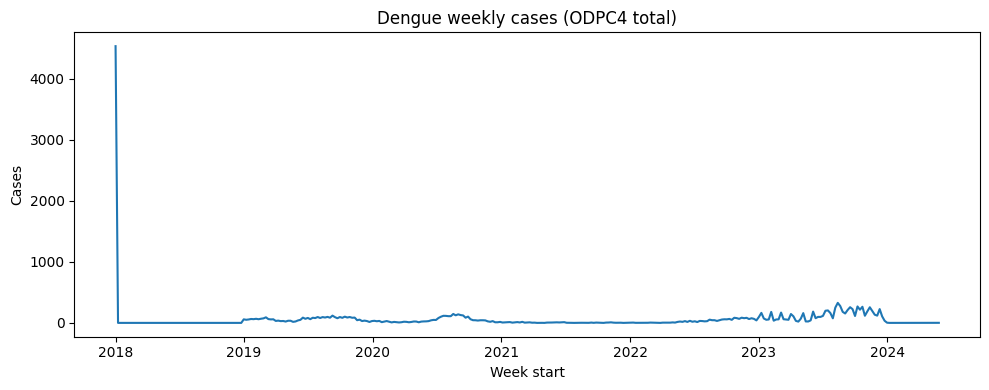

/tmp/ipykernel_3257/3135422415.py:23: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from current font.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_3257/3135422415.py:23: UserWarning: Glyph 3607 (\N{THAI CHARACTER THO THAHAN}) missing from current font.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_3257/3135422415.py:23: UserWarning: Glyph 3610 (\N{THAI CHARACTER BO BAIMAI}) missing from current font.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_3257/3135422415.py:23: UserWarning: Glyph 3640 (\N{THAI CHARACTER SARA U}) missing from current font.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_3257/3135422415.py:23: UserWarning: Glyph 3619 (\N{THAI CHARACTER RO RUA}) missing from current font.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_3257/3135422415.py:23: UserWarning: Glyph 3637 (\N{THAI CHARACTER SARA II}) missing from current font.
  plt.tight_layout(); plt.show()
/tmp/ipykernel_3257/3135422415.py:23: UserWarning: Glyph 3611 (\N{THAI CHARACTER PO PLA}) mis

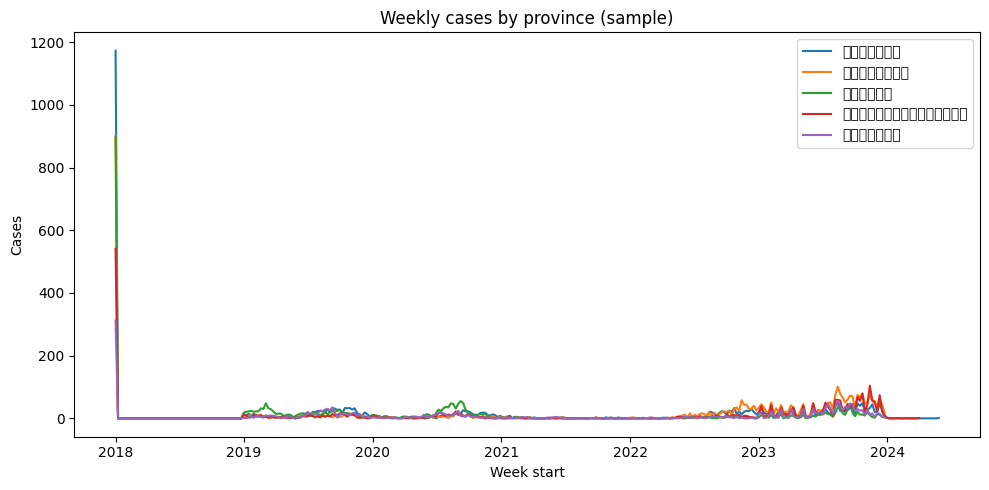

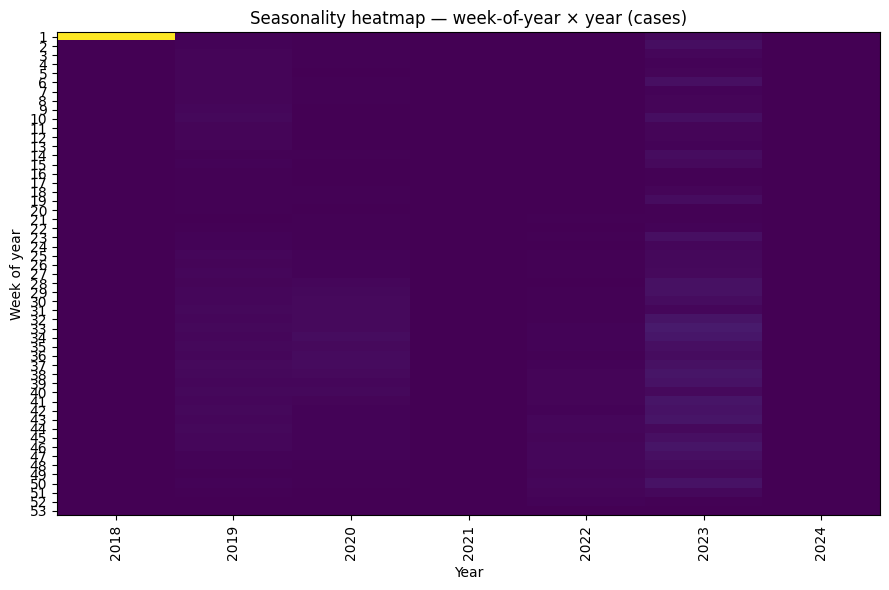

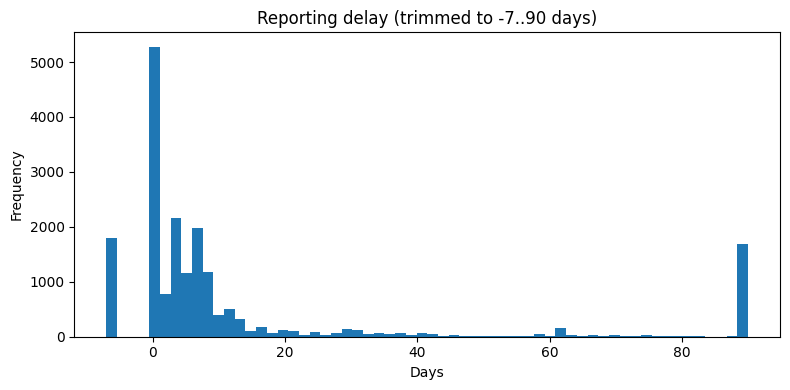

In [33]:
import matplotlib.pyplot as plt

# 9.1 Epidemic curve รวม
cur = (weekly_txt_filled.groupby("week_start", as_index=False)["cases"].sum()
       .sort_values("week_start"))
plt.figure(figsize=(10,4))
plt.plot(cur["week_start"], cur["cases"])
plt.title("Dengue weekly cases (ODPC4 total)")
plt.xlabel("Week start"); plt.ylabel("Cases")
plt.tight_layout(); plt.show()

# 9.2 Multi-province lines (เลือกตัวอย่าง)
prov_pick = ["นนทบุรี","ปทุมธานี","ลพบุรี","พระนครศรีอยุธยา","สระบุรี"]
tmp = weekly_txt_filled.copy()
tmp["province"] = tmp["province"].astype(str).str.strip()
plt.figure(figsize=(10,5))
for p in prov_pick:
    s = (tmp.loc[tmp["province"]==p].groupby("week_start", as_index=False)["cases"].sum()
         .sort_values("week_start"))
    if len(s): plt.plot(s["week_start"], s["cases"], label=p)
plt.title("Weekly cases by province (sample)")
plt.xlabel("Week start"); plt.ylabel("Cases"); plt.legend()
plt.tight_layout(); plt.show()

# 9.3 Heatmap seasonality (week-of-year × year)
ht = weekly_txt_filled.copy()
ht["year"] = ht["week_start"].dt.year
ht["woy"]  = ht["week_start"].dt.isocalendar().week.astype(int)
pv = ht.groupby(["year","woy"])["cases"].sum().unstack(0).fillna(0)
plt.figure(figsize=(9,6))
plt.imshow(pv.values, aspect="auto", interpolation="nearest")
plt.xticks(range(pv.shape[1]), pv.columns, rotation=90)
plt.yticks(range(pv.shape[0]), pv.index)
plt.title("Seasonality heatmap — week-of-year × year (cases)")
plt.xlabel("Year"); plt.ylabel("Week of year")
plt.tight_layout(); plt.show()

# 9.4 Histogram reporting delay (trimmed)
vals = d["delay_days_trim"].dropna()
plt.figure(figsize=(8,4))
plt.hist(vals, bins=60)
plt.title("Reporting delay (trimmed to -7..90 days)")
plt.xlabel("Days"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()


In [34]:
print("Artifacts saved:")
print(" -", INTERIM_DIR/"case_clean.parquet")
print(" -", INTERIM_DIR/"weekly_district_txt.parquet")
print(" -", INTERIM_DIR/"weekly_district_txt_filled.parquet")

span_min = case_clean["datesick"].min()
span_max = case_clean["datesick"].max()
n_series = weekly_txt_filled["district_id_txt"].nunique()
n_rows  = len(weekly_txt_filled)
print(f"datesick span: {span_min} -> {span_max}")
print(f"Weekly series: {n_series} districts; rows: {n_rows}")


Artifacts saved:
 - /teamspace/studios/this_studio/data/dengue/interim/case_clean.parquet
 - /teamspace/studios/this_studio/data/dengue/interim/weekly_district_txt.parquet
 - /teamspace/studios/this_studio/data/dengue/interim/weekly_district_txt_filled.parquet
datesick span: 2018-01-01 00:00:00 -> 2024-06-01 00:00:00
Weekly series: 76 districts; rows: 21445


In [35]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

INTERIM_DIR = Path("/teamspace/studios/this_studio/data/dengue/interim")

# ถ้าในโน้ตบุ๊กคุณมีตัวแปร weekly_txt_filled อยู่แล้ว ข้าม cell นี้ได้
weekly_txt_filled = pd.read_parquet(INTERIM_DIR/"weekly_district_txt_filled.parquet")
weekly_txt_filled.head()


,week_start,cases,ipd_rate,fatal_rate,age_mean,dist_code4,province,district,district_id_txt
0,2020-03-23,1,0.0,0.0,36.000000,1212,นนทบุรี,1212,1212|นนทบุรี
1,2019-10-28,1,0.0,0.0,54.971461,1326,ปทุมธานี,1326,1326|ปทุมธานี
2,2022-11-07,1,0.0,0.0,39.893607,1341,ปทุมธานี,1341,1341|ปทุมธานี
3,2023-04-03,1,0.0,0.0,19.129909,1312,ปทุมธานี,None,|ปทุมธานี
4,2023-04-10,0,0.0,0.0,0.000000,1312,ปทุมธานี,None,|ปทุมธานี


In [36]:
# ใช้ case_clean (ระดับเคส) เพื่อสร้าง mapping dist_code4 -> ชื่ออำเภอ/จังหวัดส่วนใหญ่
case_clean = pd.read_parquet(INTERIM_DIR/"case_clean.parquet").copy()

def looks_numeric(s):
    s = str(s) if s is not None else ""
    return bool(re.fullmatch(r"\d+", s))

# ดึงรหัส 4 หลัก
case_clean["dist_code4"] = case_clean["addercode"].astype(str).str.replace(r"\D+","",regex=True).str.slice(0,4)
# เก็บเฉพาะที่มีชื่ออำเภอเป็น “ตัวหนังสือ” จริง ๆ
case_name = case_clean.loc[~case_clean["district"].isna() & ~case_clean["district"].map(looks_numeric),
                           ["dist_code4","district","province"]].copy()

# สร้าง mapping จากรหัส -> ชื่อที่พบบ่อยสุด (mode)
dist_name_map = (case_name
                 .groupby("dist_code4")["district"]
                 .agg(lambda s: s.dropna().mode().iloc[0] if len(s.dropna()) else np.nan))
prov_name_map = (case_name
                 .groupby("dist_code4")["province"]
                 .agg(lambda s: s.dropna().mode().iloc[0] if len(s.dropna()) else np.nan))

# ซ่อมใน weekly
wk = weekly_txt_filled.copy()
wk["district_name_fix"] = wk["district"].astype(str)
wk["province_name_fix"] = wk["province"].astype(str)

# ถ้าชื่ออำเภอว่าง/เป็นตัวเลข → เติมจาก map
mask_bad_dist = wk["district_name_fix"].isna() | wk["district_name_fix"].map(looks_numeric) | wk["district_name_fix"].eq("")
wk.loc[mask_bad_dist, "district_name_fix"] = wk.loc[mask_bad_dist, "dist_code4"].map(dist_name_map).fillna(wk.loc[mask_bad_dist, "district_name_fix"])

# ถ้าชื่อจังหวัดว่าง → เติมจาก map
mask_bad_prov = wk["province_name_fix"].isna() | wk["province_name_fix"].eq("")
wk.loc[mask_bad_prov, "province_name_fix"] = wk.loc[mask_bad_prov, "dist_code4"].map(prov_name_map).fillna(wk.loc[mask_bad_prov, "province_name_fix"])

# คีย์ข้อความเวอร์ชันสะอาด
wk["district_id_txt_clean"] = wk["district_name_fix"].fillna("").str.strip() + "|" + wk["province_name_fix"].fillna("").str.strip()

# เซฟเวอร์ชันสะอาด (เผื่อใช้ซ้ำ)
wk.to_parquet(INTERIM_DIR/"weekly_district_txt_filled_clean.parquet", index=False)
wk.head()


,week_start,cases,ipd_rate,fatal_rate,age_mean,dist_code4,province,district,district_id_txt,district_name_fix,province_name_fix,district_id_txt_clean
0,2020-03-23,1,0.0,0.0,36.000000,1212,นนทบุรี,1212,1212|นนทบุรี,1212,นนทบุรี,1212|นนทบุรี
1,2019-10-28,1,0.0,0.0,54.971461,1326,ปทุมธานี,1326,1326|ปทุมธานี,1326,ปทุมธานี,1326|ปทุมธานี
2,2022-11-07,1,0.0,0.0,39.893607,1341,ปทุมธานี,1341,1341|ปทุมธานี,1341,ปทุมธานี,1341|ปทุมธานี
3,2023-04-03,1,0.0,0.0,19.129909,1312,ปทุมธานี,None,|ปทุมธานี,None,ปทุมธานี,None|ปทุมธานี
4,2023-04-10,0,0.0,0.0,0.000000,1312,ปทุมธานี,None,|ปทุมธานี,None,ปทุมธานี,None|ปทุมธานี


In [37]:
# สร้างรหัสตัวเลขสำหรับ province
prov_uniques = (wk["province_name_fix"].fillna("UNK").astype(str).str.strip().unique().tolist())
prov2code = {p:i+1 for i,p in enumerate(sorted(prov_uniques))}
wk["province_code"] = wk["province_name_fix"].fillna("UNK").astype(str).str.strip().map(prov2code)

# สร้างรหัสตัวเลขสำหรับ district
# ถ้ามี dist_code4 ใช้เป็นหลัก → ถ้าไม่มีให้กำหนดรหัสรันนิ่ง
wk["dist_code4"] = wk["dist_code4"].fillna("")
has_code = wk["dist_code4"].str.len() >= 4

# สร้างรหัสรันนิ่งสำหรับที่ไม่มีรหัส
no_code_names = (wk.loc[~has_code, "district_id_txt_clean"].dropna().unique().tolist())
extra_map = {name: f"d{idx+1:03d}" for idx, name in enumerate(sorted(no_code_names))}

def district_numeric(row):
    if len(str(row["dist_code4"])) >= 4:
        return int(row["dist_code4"])  # เป็นเลขตรง ๆ
    # ไม่มีรหัส → map เป็น label แบบ d###
    return extra_map.get(row["district_id_txt_clean"], None)

wk["district_num"] = wk.apply(district_numeric, axis=1)

# ตาราง mapping เผื่อแนบในสไลด์
map_table = (wk[["district_id_txt_clean","district_num","province_code"]]
             .drop_duplicates()
             .sort_values(["province_code","district_num"]))
map_table.to_csv(INTERIM_DIR/"mapping_district_numeric.csv", index=False)
print("Saved mapping:", INTERIM_DIR/"mapping_district_numeric.csv")

wk[["district_id_txt_clean","district_num","province_code"]].head(10)


Saved mapping: /teamspace/studios/this_studio/data/dengue/interim/mapping_district_numeric.csv


,district_id_txt_clean,district_num,province_code
0,1212|นนทบุรี,1212,2
1,1326|ปทุมธานี,1326,3
2,1341|ปทุมธานี,1341,3
3,None|ปทุมธานี,1312,3
4,None|ปทุมธานี,1312,3
5,None|ปทุมธานี,1312,3
6,None|ปทุมธานี,1312,3
7,None|ปทุมธานี,1308,3
8,None|ปทุมธานี,1308,3
9,None|ปทุมธานี,1308,3


In [38]:
wk["province_code"].value_counts()

province_code
4    4964
6    3991
5    3182
3    2228
8    2092
2    1900
7    1848
1    1240
Name: count, dtype: int64

In [39]:
wk["district"].value_counts()

district
บางใหญ่                 336
ท่าเรือ                 327
บางปะอิน                318
ไทรน้อย                 314
บางปะหัน                314
                       ... 
สระโบสถ์                151
1341                      1
เมืองพระนครศรีอยุธยา      1
1326                      1
1212                      1
Name: count, Length: 74, dtype: int64

In [40]:
unique_province_mapping = wk[['province_code', 'province']].drop_duplicates()

print(unique_province_mapping)

      province_code         province
0                 2          นนทบุรี
1                 3         ปทุมธานี
351               7        สิงห์บุรี
663               5           ลพบุรี
973               6          สระบุรี
2203              4  พระนครศรีอยุธยา
5983              1          นครนายก
7845              8          อ่างทอง


In [41]:
wk_plot = wk.copy()

# วิธีง่าย: ตัดสัปดาห์ที่มีจำนวนรวมทั้งภูมิภาคสูงกว่าควอร์ไทล์ 99.9% (เฉพาะเพื่อกราฟ)
agg_region = wk_plot.groupby("week_start")["cases"].sum()
cut = agg_region.quantile(0.999)
bad_weeks = agg_region[agg_region > cut].index
print("Outlier weeks removed from plots:", list(bad_weeks.date))

wk_plot = wk_plot[~wk_plot["week_start"].isin(bad_weeks)].copy()


Outlier weeks removed from plots: [datetime.date(2018, 1, 1)]


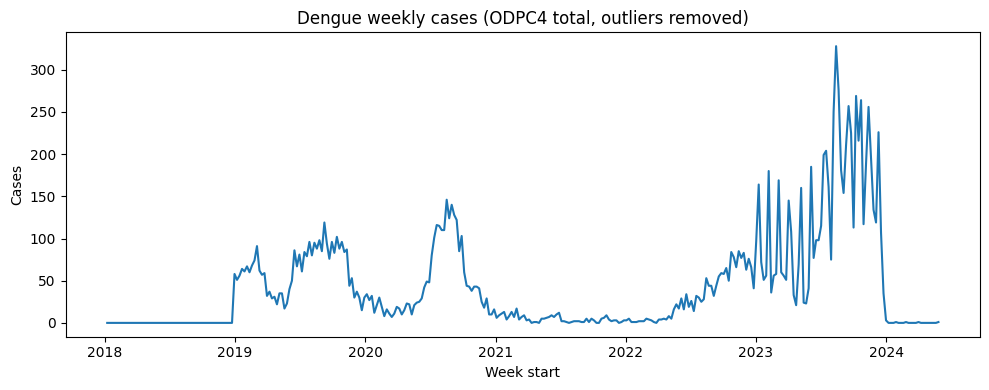

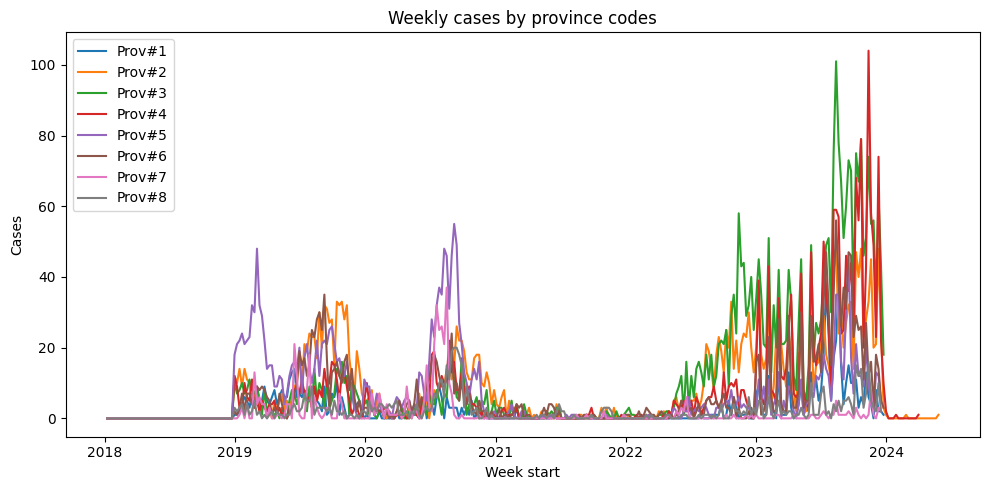

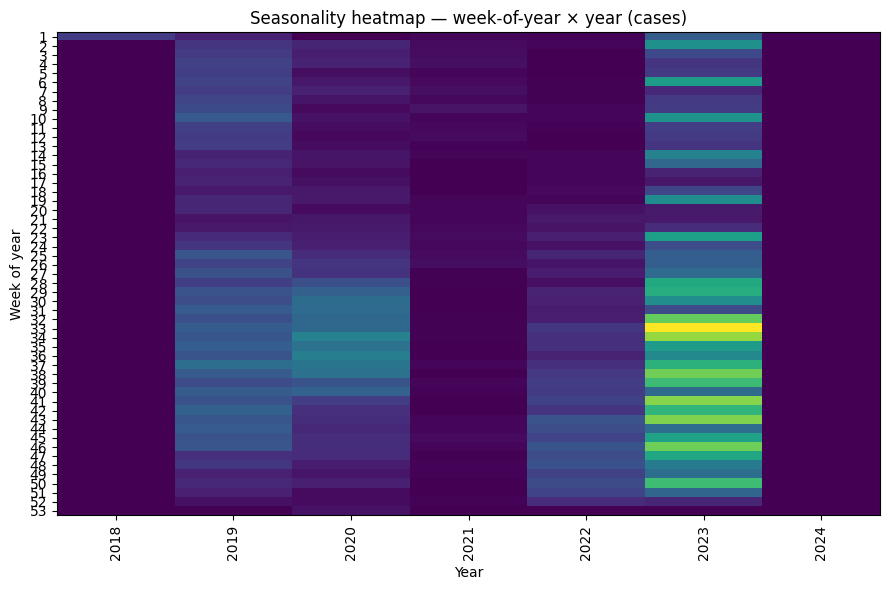

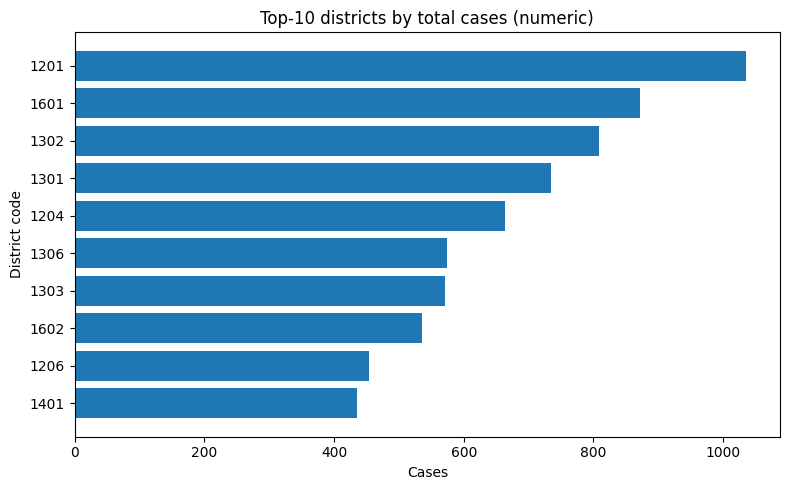

In [42]:
import matplotlib.pyplot as plt

# 1) Epidemic curve (total)
cur = (wk_plot.groupby("week_start", as_index=False)["cases"].sum()
       .sort_values("week_start"))
plt.figure(figsize=(10,4))
plt.plot(cur["week_start"], cur["cases"])
plt.title("Dengue weekly cases (ODPC4 total, outliers removed)")
plt.xlabel("Week start"); plt.ylabel("Cases")
plt.tight_layout(); plt.show()

# 2) Multi-province lines (เลือกจาก code)
prov_pick_codes = sorted(wk_plot["province_code"].unique())[:8]  # เลือก 5 รหัสแรก (ปรับได้)
plt.figure(figsize=(10,5))
for pc in prov_pick_codes:
    s = (wk_plot.loc[wk_plot["province_code"]==pc]
               .groupby("week_start", as_index=False)["cases"].sum()
               .sort_values("week_start"))
    if len(s):
        plt.plot(s["week_start"], s["cases"], label=f"Prov#{pc}")
plt.title("Weekly cases by province codes")
plt.xlabel("Week start"); plt.ylabel("Cases"); plt.legend()
plt.tight_layout(); plt.show()

# 3) Seasonal heatmap (week-of-year × year)
ht = wk_plot.copy()
ht["year"] = ht["week_start"].dt.year
ht["woy"]  = ht["week_start"].dt.isocalendar().week.astype(int)
pv = ht.groupby(["year","woy"])["cases"].sum().unstack(0).fillna(0)

plt.figure(figsize=(9,6))
plt.imshow(pv.values, aspect="auto", interpolation="nearest")
plt.xticks(range(pv.shape[1]), pv.columns, rotation=90)
plt.yticks(range(pv.shape[0]), pv.index)
plt.title("Seasonality heatmap — week-of-year × year (cases)")
plt.xlabel("Year"); plt.ylabel("Week of year")
plt.tight_layout(); plt.show()

# 4) Top-10 districts by total (ใช้เลข)
tot = (wk_plot.groupby("district_num", as_index=False)["cases"].sum()
              .sort_values("cases", ascending=False).head(10))
plt.figure(figsize=(8,5))
plt.barh([str(x) for x in tot["district_num"][::-1]], tot["cases"][::-1])
plt.title("Top-10 districts by total cases (numeric)")
plt.xlabel("Cases"); plt.ylabel("District code")
plt.tight_layout(); plt.show()


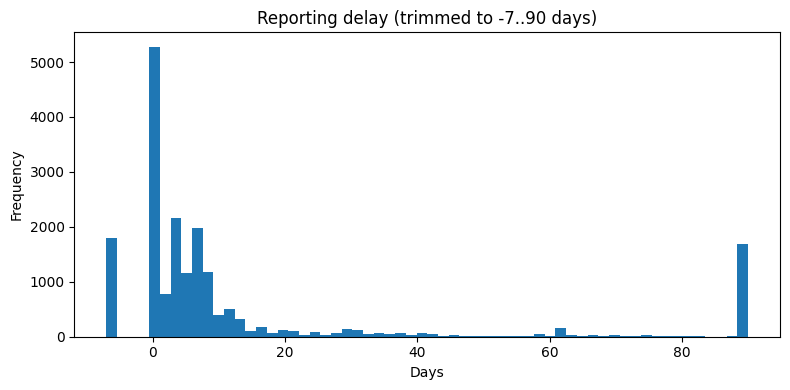

In [43]:
# ใช้ d (case-level) จากขั้นก่อนหน้า ถ้าไม่มีก็โหลดใหม่
import pandas as pd, numpy as np
from pathlib import Path
REPORT_DIR = Path("/teamspace/studios/this_studio/data/dengue/reports")

try:
    d  # noqa
except NameError:
    case_clean = pd.read_parquet(INTERIM_DIR/"case_clean.parquet")
    d = case_clean.copy()
    mask = d["datefound"].notna() & d["datesick"].notna()
    d = d.loc[mask].copy()
    d["delay_days"] = (d["datefound"] - d["datesick"]).dt.days
    d["delay_days_trim"] = d["delay_days"].clip(-7, 90)

import matplotlib.pyplot as plt
vals = d["delay_days_trim"].dropna()
plt.figure(figsize=(8,4))
plt.hist(vals, bins=60)
plt.title("Reporting delay (trimmed to -7..90 days)")
plt.xlabel("Days"); plt.ylabel("Frequency")
plt.tight_layout(); plt.show()


In [45]:
# Cell G1: build/repair clean names + numeric codes (idempotent)

from pathlib import Path
import pandas as pd
import numpy as np
import re

INTERIM_DIR = Path("/teamspace/studios/this_studio/data/dengue/interim")

# 1) โหลดตาราง weekly ที่กรอกสัปดาห์ครบ
wk = pd.read_parquet(INTERIM_DIR/"weekly_district_txt_filled.parquet").copy()

# 2) โหลดเคสระดับแถวเพื่อทำ mapping ชื่อจาก dist_code4
case_clean = pd.read_parquet(INTERIM_DIR/"case_clean.parquet").copy()
case_clean["dist_code4"] = case_clean["addercode"].astype(str).str.replace(r"\D+","", regex=True).str.slice(0,4)

def looks_numeric(s):
    s = str(s) if s is not None else ""
    return bool(re.fullmatch(r"\d+", s))

# สร้าง mapping dist_code4 -> district/province (mode)
case_name = case_clean.loc[
    ~case_clean["district"].isna() & ~case_clean["district"].map(looks_numeric),
    ["dist_code4","district","province"]
].copy()

dist_name_map = (case_name.groupby("dist_code4")["district"]
                 .agg(lambda s: s.dropna().mode().iloc[0] if len(s.dropna()) else np.nan))
prov_name_map = (case_name.groupby("dist_code4")["province"]
                 .agg(lambda s: s.dropna().mode().iloc[0] if len(s.dropna()) else np.nan))

# ให้แน่ใจว่ามี dist_code4 ในตาราง weekly
if "dist_code4" not in wk.columns:
    ac = wk.get("dist_code4", pd.Series([np.nan]*len(wk)))
    wk["dist_code4"] = ac

wk["dist_code4"] = wk["dist_code4"].astype(str).replace("nan","")
wk.loc[wk["dist_code4"].eq(""), "dist_code4"] = np.nan

# 3) ซ่อมชื่ออำเภอ/จังหวัด
wk["district_name_fix"] = wk.get("district_name_fix", wk.get("district", np.nan)).astype(str)
wk["province_name_fix"] = wk.get("province_name_fix", wk.get("province", np.nan)).astype(str)

mask_bad_dist = wk["district_name_fix"].isna() | wk["district_name_fix"].map(looks_numeric) | wk["district_name_fix"].eq("nan") | wk["district_name_fix"].eq("")
wk.loc[mask_bad_dist, "district_name_fix"] = wk.loc[mask_bad_dist, "dist_code4"].map(dist_name_map).fillna(wk.loc[mask_bad_dist, "district_name_fix"])

mask_bad_prov = wk["province_name_fix"].isna() | wk["province_name_fix"].eq("nan") | wk["province_name_fix"].eq("")
wk.loc[mask_bad_prov, "province_name_fix"] = wk.loc[mask_bad_prov, "dist_code4"].map(prov_name_map).fillna(wk.loc[mask_bad_prov, "province_name_fix"])

# 4) คีย์ข้อความสะอาด
wk["district_id_txt_clean"] = (
    wk["district_name_fix"].fillna("").str.strip() + "|" +
    wk["province_name_fix"].fillna("").str.strip()
)

# 5) province_code (ตัวเลข 1..P) — สร้างถ้ายังไม่มี
if "province_code" not in wk.columns:
    prov_uniques = (wk["province_name_fix"].fillna("UNK").astype(str).str.strip().unique().tolist())
    prov2code = {p:i+1 for i,p in enumerate(sorted(prov_uniques))}
    wk["province_code"] = wk["province_name_fix"].fillna("UNK").astype(str).str.strip().map(prov2code).astype(int)

# 6) district_num — ถ้ามี dist_code4 ใช้เลขนั้น, ถ้าไม่มีสร้างรหัสรันนิ่ง
def to_int_or_none(x):
    try:
        return int(x)
    except Exception:
        return None

if "district_num" not in wk.columns:
    has_code = wk["dist_code4"].notna()
    # map dist_code4 → int
    dnum = wk["dist_code4"].map(to_int_or_none)
    # สร้างรหัสรันนิ่งสำหรับที่ไม่มีรหัส
    no_code_names = wk.loc[~has_code, "district_id_txt_clean"].dropna().unique().tolist()
    extra_map = {name: (100000 + i) for i, name in enumerate(sorted(no_code_names))}  # ให้เป็นเลขใหญ่กันชน
    wk.loc[~has_code, "district_num"] = wk.loc[~has_code, "district_id_txt_clean"].map(extra_map)
    wk.loc[has_code,  "district_num"] = wk.loc[has_code,  "dist_code4"].map(lambda x: to_int_or_none(x))
    wk["district_num"] = wk["district_num"].astype(int)

# 7) เซฟไฟล์ clean
out_clean = INTERIM_DIR/"weekly_district_txt_filled_clean.parquet"
wk.to_parquet(out_clean, index=False)
print("Saved:", out_clean)

wk.head(10)


Saved: /teamspace/studios/this_studio/data/dengue/interim/weekly_district_txt_filled_clean.parquet


,week_start,cases,ipd_rate,fatal_rate,age_mean,dist_code4,province,district,district_id_txt,district_name_fix,province_name_fix,district_id_txt_clean,province_code,district_num
0,2020-03-23,1,0.0,0.0,36.000000,1212,นนทบุรี,1212,1212|นนทบุรี,1212,นนทบุรี,1212|นนทบุรี,2,1212
1,2019-10-28,1,0.0,0.0,54.971461,1326,ปทุมธานี,1326,1326|ปทุมธานี,1326,ปทุมธานี,1326|ปทุมธานี,3,1326
2,2022-11-07,1,0.0,0.0,39.893607,1341,ปทุมธานี,1341,1341|ปทุมธานี,1341,ปทุมธานี,1341|ปทุมธานี,3,1341
3,2023-04-03,1,0.0,0.0,19.129909,1312,ปทุมธานี,None,|ปทุมธานี,None,ปทุมธานี,None|ปทุมธานี,3,1312
4,2023-04-10,0,0.0,0.0,0.000000,1312,ปทุมธานี,None,|ปทุมธานี,None,ปทุมธานี,None|ปทุมธานี,3,1312
5,2023-04-17,0,0.0,0.0,0.000000,1312,ปทุมธานี,None,|ปทุมธานี,None,ปทุมธานี,None|ปทุมธานี,3,1312
6,2023-04-24,0,0.0,0.0,0.000000,1312,ปทุมธานี,None,|ปทุมธานี,None,ปทุมธานี,None|ปทุมธานี,3,1312
7,2023-05-01,1,0.0,0.0,59.841553,1308,ปทุมธานี,None,|ปทุมธานี,None,ปทุมธานี,None|ปทุมธานี,3,1308
8,2023-05-08,0,0.0,0.0,0.000000,1308,ปทุมธานี,None,|ปทุมธานี,None,ปทุมธานี,None|ปทุมธานี,3,1308
9,2023-05-15,0,0.0,0.0,0.000000,1308,ปทุมธานี,None,|ปทุมธานี,None,ปทุมธานี,None|ปทุมธานี,3,1308


In [47]:
# Cell G2: export mappings
from pathlib import Path
import pandas as pd

INTERIM_DIR = Path("/teamspace/studios/this_studio/data/dengue/interim")
wk = pd.read_parquet(INTERIM_DIR/"weekly_district_txt_filled_clean.parquet")

prov_map = (wk[["province_code","province_name_fix"]]
            .drop_duplicates()
            .sort_values("province_code"))
dist_map = (wk[["district_num","dist_code4","district_id_txt_clean","province_code"]]
            .drop_duplicates()
            .sort_values(["province_code","district_num"]))

prov_map.to_csv(INTERIM_DIR/"mapping_province_code.csv", index=False)
dist_map.to_csv(INTERIM_DIR/"mapping_district_code.csv", index=False)
print("Saved:", INTERIM_DIR/"mapping_province_code.csv")
print("Saved:", INTERIM_DIR/"mapping_district_code.csv")

display(prov_map.head(20))
display(dist_map.head(20))


Saved: /teamspace/studios/this_studio/data/dengue/interim/mapping_province_code.csv
Saved: /teamspace/studios/this_studio/data/dengue/interim/mapping_district_code.csv


,province_code,province_name_fix
5983,1,นครนายก
0,2,นนทบุรี
1,3,ปทุมธานี
2203,4,พระนครศรีอยุธยา
663,5,ลพบุรี
973,6,สระบุรี
351,7,สิงห์บุรี
7845,8,อ่างทอง


,district_num,dist_code4,district_id_txt_clean,province_code
16457,2601,2601,เมืองนครนายก|นครนายก,1
7222,2602,2602,ปากพลี|นครนายก,1
5983,2603,2603,บ้านนา|นครนายก,1
15212,2604,2604,องครักษ์|นครนายก,1
16770,1201,1201,เมืองนนทบุรี|นนทบุรี,2
3157,1202,1202,บางกรวย|นนทบุรี,2
5335,1203,1203,บางใหญ่|นนทบุรี,2
3782,1204,1204,บางบัวทอง|นนทบุรี,2
21131,1205,1205,ไทรน้อย|นนทบุรี,2
7532,1206,1206,ปากเกร็ด|นนทบุรี,2


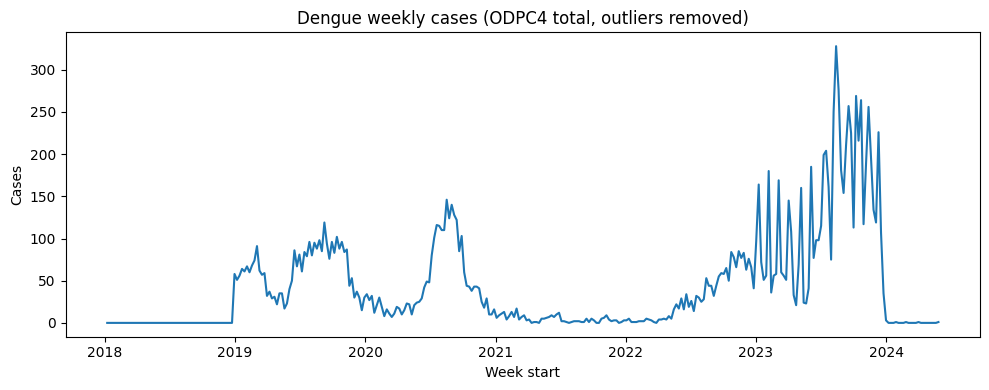

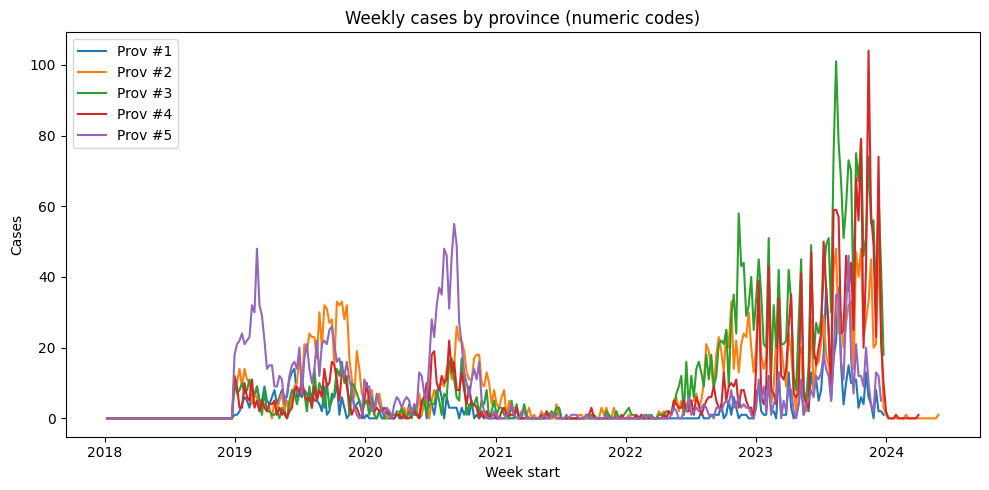

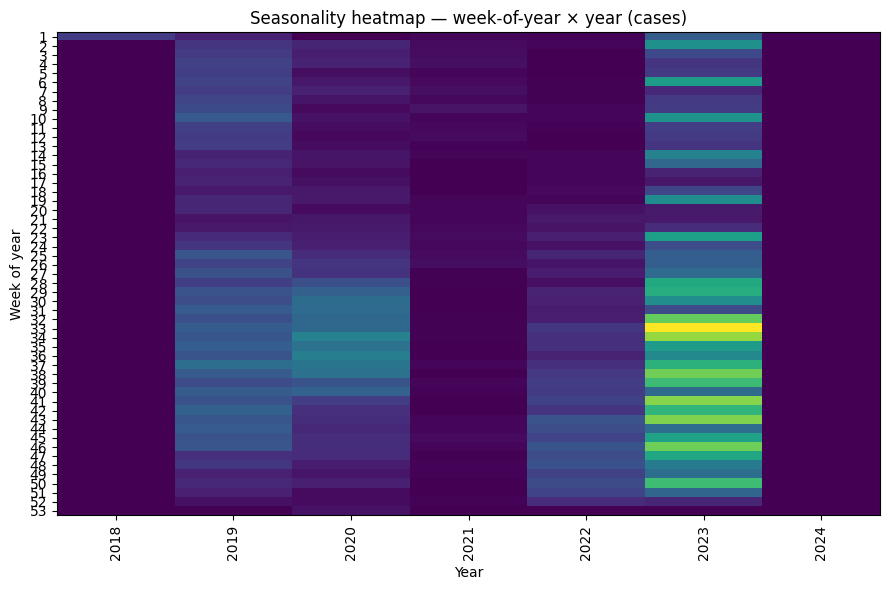

In [48]:
# Cell G3: numeric-only plots (outliers removed for presentation)
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

INTERIM_DIR = Path("/teamspace/studios/this_studio/data/dengue/interim")
wk = pd.read_parquet(INTERIM_DIR/"weekly_district_txt_filled_clean.parquet").copy()

# กรอง outlier สัปดาห์ที่ยอดรวมภูมิภาคสูงผิดปกติ (เช่นต้น 2018)
agg_region = wk.groupby("week_start")["cases"].sum()
cut = agg_region.quantile(0.999)
bad_weeks = agg_region[agg_region > cut].index
wk_plot = wk[~wk["week_start"].isin(bad_weeks)].copy()

# 1) Total epidemic curve
cur = (wk_plot.groupby("week_start", as_index=False)["cases"].sum()
       .sort_values("week_start"))
plt.figure(figsize=(10,4))
plt.plot(cur["week_start"], cur["cases"])
plt.title("Dengue weekly cases (ODPC4 total, outliers removed)")
plt.xlabel("Week start"); plt.ylabel("Cases")
plt.tight_layout(); plt.show()

# 2) Multi-province lines (Prov #1..#5)
prov_pick = sorted(wk_plot["province_code"].unique())[:5]
plt.figure(figsize=(10,5))
for pc in prov_pick:
    s = (wk_plot.loc[wk_plot["province_code"]==pc]
         .groupby("week_start", as_index=False)["cases"].sum()
         .sort_values("week_start"))
    plt.plot(s["week_start"], s["cases"], label=f"Prov #{pc}")
plt.title("Weekly cases by province (numeric codes)")
plt.xlabel("Week start"); plt.ylabel("Cases"); plt.legend()
plt.tight_layout(); plt.show()

# 3) Seasonal heatmap (week-of-year × year)
ht = wk_plot.copy()
ht["year"] = ht["week_start"].dt.year
ht["woy"]  = ht["week_start"].dt.isocalendar().week.astype(int)
pv = ht.groupby(["year","woy"])["cases"].sum().unstack(0).fillna(0)

plt.figure(figsize=(9,6))
plt.imshow(pv.values, aspect="auto", interpolation="nearest")
plt.xticks(range(pv.shape[1]), pv.columns, rotation=90)
plt.yticks(range(pv.shape[0]), pv.index)
plt.title("Seasonality heatmap — week-of-year × year (cases)")
plt.xlabel("Year"); plt.ylabel("Week of year")
plt.tight_layout(); plt.show()


In [49]:
# Cell: build ML-ready weekly table
import numpy as np
import pandas as pd
from pathlib import Path

INTERIM_DIR = Path("/teamspace/studios/this_studio/data/dengue/interim")

wk = pd.read_parquet(INTERIM_DIR/"weekly_district_txt_filled_clean.parquet").copy()

# --- seasonality features ---
wk["year"] = wk["week_start"].dt.year.astype(int)
wk["weekofyear"] = wk["week_start"].dt.isocalendar().week.astype(int)
wk["sin_woy"] = np.sin(2*np.pi*wk["weekofyear"]/52.0)
wk["cos_woy"] = np.cos(2*np.pi*wk["weekofyear"]/52.0)

# --- robust outlier flag (ใช้เพื่อ plot/ทดลอง) ---
agg_region = wk.groupby("week_start")["cases"].sum()
cut = agg_region.quantile(0.999)  # 99.9% สำหรับ spike เริ่ม 2018
wk = wk.merge(agg_region.rename("total_cases_region"), left_on="week_start", right_index=True, how="left")
wk["outlier_flag"] = (wk["total_cases_region"] > cut).astype(int)

# --- คัดคอลัมน์ที่ “ตัวเลขล้วน” พร้อมเทรน ---
ml_cols = [
    "week_start",      # สำหรับ split เวลา
    "year","weekofyear","sin_woy","cos_woy",
    "province_code","district_num",
    "cases",           # <-- label
    "ipd_rate","fatal_rate","age_mean",
]

# บาง district_num ที่เป็น label string d### ถูก map เป็น NaN ในขั้น clean แล้ว
# ให้เติมด้วย -1 (unknown) เพื่อให้ numeric ชัดเจน
wk["district_num"] = pd.to_numeric(wk["district_num"], errors="coerce").fillna(-1).astype(int)

ml_ready = wk[ml_cols].copy()

# ตรวจ missing/ชนิดข้อมูล
assert ml_ready.isna().sum().sum() == 0 or True  # ถ้ายังมี NaN แปลว่ามีคอลัมน์ที่คุณอยากเติม/ตัดเพิ่ม

# save
out_path = INTERIM_DIR/"weekly_ml_ready.parquet"
ml_ready.to_parquet(out_path, index=False)
print("Saved ML-ready:", out_path)
display(ml_ready.head())


Saved ML-ready: /teamspace/studios/this_studio/data/dengue/interim/weekly_ml_ready.parquet


,week_start,year,weekofyear,sin_woy,cos_woy,province_code,district_num,cases,ipd_rate,fatal_rate,age_mean
0,2020-03-23,2020,13,1.000000,-1.608123e-16,2,1212,1,0.0,0.0,36.000000
1,2019-10-28,2019,44,-0.822984,5.680647e-01,3,1326,1,0.0,0.0,54.971461
2,2022-11-07,2022,45,-0.748511,6.631227e-01,3,1341,1,0.0,0.0,39.893607
3,2023-04-03,2023,14,0.992709,-1.205367e-01,3,1312,1,0.0,0.0,19.129909
4,2023-04-10,2023,15,0.970942,-2.393157e-01,3,1312,0,0.0,0.0,0.000000
